In [1]:
import earthaccess
auth = earthaccess.login()
# are we authenticated?
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [33]:
bbox = (3, 3, 7, 9, ) #(lat_min, lon_min, lat_max, lon_max)

import xarray as xr
results = earthaccess.search_data(
    short_name = "PACE_OCI_L2_AOP",
    temporal = ("2025-06-03", "2025-06-03"),
    bounding_box = bbox #(lat_min, lon_min, lat_max, lon_max)
)
fileset = earthaccess.open(results);

QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
fileset

[<File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250605T124214.L2.OC_AOP.V3_1.nc>,
 <File-like object S3FileSystem, ob-cumulus-prod-public/PACE_OCI.20250605T124714.L2.OC_AOP.V3_1.nc>]

In [34]:
# open_datatree is for netcdf files with groups
datatree = xr.open_datatree(fileset[0], decode_timedelta=False, chunks={}) 
datatree.groups

('/',
 '/sensor_band_parameters',
 '/scan_line_attributes',
 '/geophysical_data',
 '/navigation_data',
 '/processing_control',
 '/processing_control/input_parameters',
 '/processing_control/flag_percentages')

In [35]:
# We merge the groups all together so we have the lat/lon and 
# This works due to the values in each group have the same shape.
ds = xr.merge(datatree.to_dict().values())
ds = ds.set_coords(("longitude", "latitude"))
ds

<xarray.Dataset> Size: 3GB
Dimensions:        (number_of_bands: 286, number_of_reflective_bands: 286,
                    wavelength_3d: 172, number_of_lines: 1710,
                    pixels_per_line: 1272)
Coordinates:
  * wavelength_3d  (wavelength_3d) float64 1kB 346.0 348.0 351.0 ... 717.0 719.0
    longitude      (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    latitude       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
Dimensions without coordinates: number_of_bands, number_of_reflective_bands,
                                number_of_lines, pixels_per_line
Data variables: (12/30)
    wavelength     (number_of_bands) float64 2kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_gain      (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    vcal_offset    (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    F0             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    aw             (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    bbw            (number_of_reflective_bands) float32 1kB dask.array<chunksize=(32,), meta=np.ndarray>
    ...             ...
    aot_865        (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    angstrom       (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    avw            (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    nflh           (number_of_lines, pixels_per_line) float32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    l2_flags       (number_of_lines, pixels_per_line) int32 9MB dask.array<chunksize=(256, 1272), meta=np.ndarray>
    tilt           (number_of_lines) float32 7kB dask.array<chunksize=(32,), meta=np.ndarray>
Attributes: (12/47)
    title:                             OCI Level-2 Data AOP
    product_name:                      PACE_OCI.20250603T113641.L2.OC_AOP.V3_...
    processing_version:                3.1
    history:                           l2gen par=/data9/sdpsoper/vdc/vpu8/wor...
    instrument:                        OCI
    platform:                          PACE
    ...                                ...
    geospatial_lon_min:                3.7621722
    startDirection:                    Ascending
    endDirection:                      Ascending
    day_night_flag:                    Day
    earth_sun_distance_correction:     0.9718677401542664
    geospatial_bounds:                 POLYGON ((29.32188 25.19884, 3.76217 2...

In [36]:
# Fix a chunk mismatch and check the chunking; ignore the warning
# We are good for dask backed operations
ds = ds.unify_chunks()
ds.chunks

/srv/conda/envs/notebook/lib/python3.12/site-packages/xarray/structure/chunks.py:180: PerformanceWarning: Increasing number of chunks by factor of 81
  _, chunked_data = chunkmanager.unify_chunks(*unify_chunks_args)


Frozen({'number_of_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_reflective_bands': (32, 32, 32, 32, 32, 32, 32, 32, 30), 'number_of_lines': (32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 14), 'pixels_per_line': (256, 256, 256, 256, 248), 'wavelength_3d': (40, 40, 40, 40, 12)})

In [15]:
# ---- Load Libraries ----
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from scipy.integrate import trapezoid
from scipy.spatial import cKDTree
from matplotlib.colors import Normalize

In [37]:
# Assign core variables; for convenience during plotting
rrs_da = ds["Rrs"]
avw_da = ds["avw"]
wavelengths = ds["wavelength_3d"]

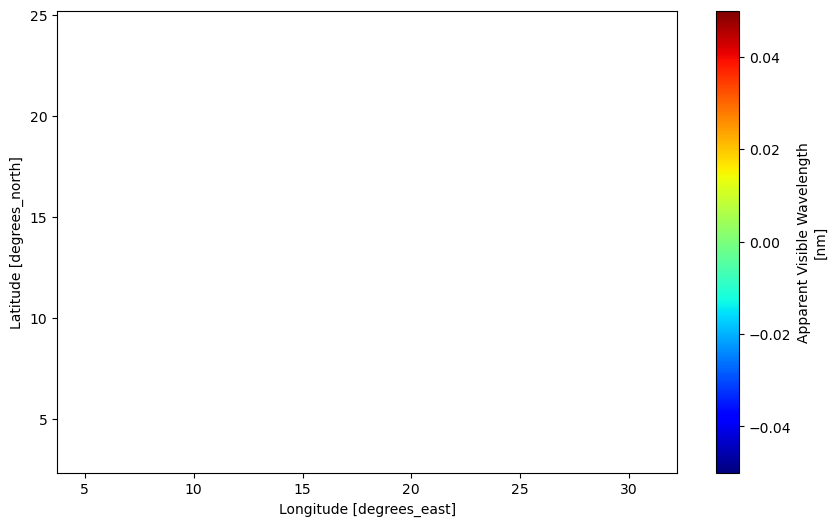

In [38]:
fig, ax = plt.subplots(figsize=(10, 6))
img = avw_da.plot(x="longitude", y="latitude", cmap="jet")

/srv/conda/envs/notebook/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1598: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(
/srv/conda/envs/notebook/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1598: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


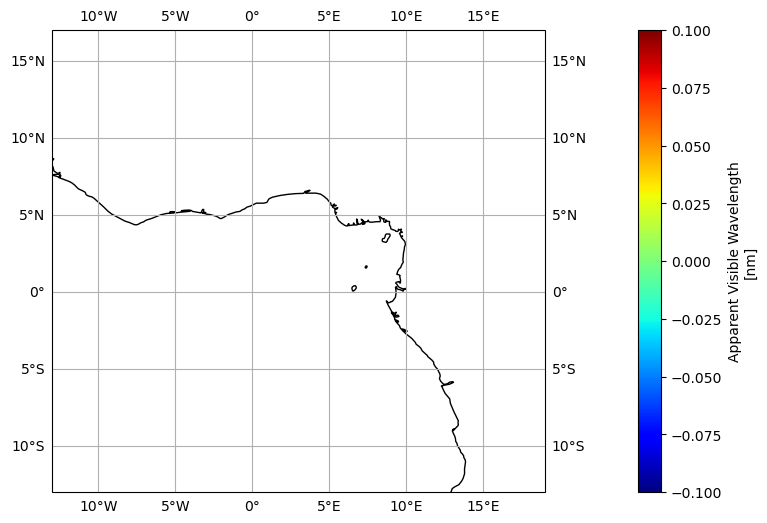

In [39]:
# This first part helps get rid of outliers that might mess up your plot
vmin = float(avw_da.quantile(0.01))
vmax = float(avw_da.quantile(0.99))

# Get the figure set up, add a map projection
fig, ax = plt.subplots(figsize=(12, 6), subplot_kw={"projection": ccrs.PlateCarree()})

# Put some lines in there so we know where we are
ax.gridlines(draw_labels=True)
ax.coastlines()

# Crop the image down a bit so we can focus on an area
ax.set_extent([-13, 19, -13, 17], crs=ccrs.PlateCarree()) #lonmin, lonmax, latmin, latmax

# Plot and adjust colorbar limits, put "pad" argument in there to move the colorbar away from the image (otherwise it overlaps)
img = avw_da.plot(x="longitude", y="latitude", cmap="jet", vmin=vmin, vmax=vmax, ax=ax, cbar_kwargs={"pad": 0.1})